<a href="https://colab.research.google.com/github/sayid-alt/sentiment-analysis-nlp/blob/main/Sentiment_analyst_prediction_with_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dataset: [kaggle](https://www.kaggle.com/datasets/damirolejar/sentiment-analysis-nlp-trainset-data?select=final_negative.txt)

See copied project on [github](https://github.com/sayid-alt/sentiment-analysis-nlp)

# Import library

In [33]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Embedding
from google.colab import files


import os
import zipfile
import urllib.request

# Utilities

In [4]:
DOWNLOAD_URL = 'https://github.com/sayid-alt/sentiment-analysis-nlp/raw/main/text.zip'
DOWNLOAD_DIR = os.path.join(os.getcwd(), 'datasets')

def download_data(url=DOWNLOAD_URL, dir=DOWNLOAD_DIR):
    # Downloading data
    print('Downloading data...')
    if not os.path.exists(dir):
        os.makedirs(dir)

    zip_path = os.path.join(dir, 'text.zip')
    urllib.request.urlretrieve(url, zip_path)
    print(f'Success downloading data to {zip_path}')

    # Extract zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dir)
        print(f'Success extracting data to {dir}')


# prep data from text file to variable in list type
def prep_data_txt(filepath):
  '''
    filepath: path for text file
    return: list of text
  '''
  datalist = []
  with open(filepath, 'r') as file:
    lines = file.readlines()
    for line in lines:
      datalist.append(line.strip())
  return datalist


# retrieve data
def retrieve_sentiment_data():
  '''
    return: neg_text, pos_text, ne_text as the dataset for sentiment analysis
  '''
  neg_text = prep_data_txt(os.path.join(data_dir, 'final_negative.txt')) #negative data
  pos_text = prep_data_txt(os.path.join(data_dir, 'final_positive.txt'))# positif data
  ne_text = prep_data_txt(os.path.join(data_dir, 'final_neutral.txt'))

  print(f'Negative data length: {len(neg_text)}')
  print(f'Positive data length: {len(pos_text)}')
  print(f'neutral data length: {len(ne_text)}')

  return neg_text, pos_text, ne_text

def stratified_split():
  # split data using stratified with size train/val/test 80/10/10 respectively
  sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
  train_index, test_index = next(sss.split(df['sentiment'], df['label']))

  # split throug test size for get validation split
  sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
  val_index, test_index = next(sss_val.split(df.iloc[test_index]['sentiment'], df.iloc[test_index]['label']))

  return train_index, val_index, test_index

# Download data

In [5]:
download_data()

Success downloading data to /content/datasets/text.zip
Success extracting data to /content/datasets


# Generate Data

In [6]:
data_dir = os.path.join(DOWNLOAD_DIR, 'text')
print(os.listdir(data_dir))

['final_negative.txt', 'final_positive.txt', 'final_neutral.txt']


In [7]:
neg_text, pos_text, ne_text = retrieve_sentiment_data()

Negative data length: 99999
Positive data length: 100000
neutral data length: 99999


# Data Preprocessing

## Distribution

Below we merge all data into 3 sentiment categories:
- 0: Negative sentiment
- 1: Positif sentiment
- 2: neutral sentimen

In [8]:
df = pd.DataFrame({
    'sentiment' : neg_text + pos_text + ne_text,
    'label' : ['negative'] * len(neg_text) + ['positive'] * len(pos_text) + ['neutral'] * len(ne_text)
})
df.head()

,sentiment,label
0,Mothers will not give their sons as sacrifices...,negative
1,That which was meant to be conducive to life h...,negative
2,The Jews were expecting the appearance of the ...,negative
3,We have forsaken the path of God; we have give...,negative
4,"Sixth, the Messiah was to gather together all ...",negative


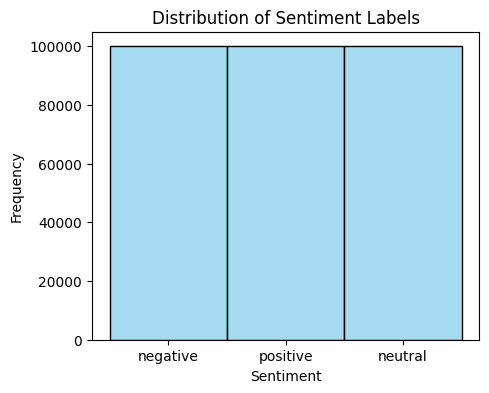

In [9]:
plt.figure(figsize=(5, 4))
sns.histplot(df, x='label', bins=3, color='skyblue')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

## Split data

Split data, using stratified shuffle split from sklearn []:
- Train: 80
- Val: 10
- test: 10

In [10]:
# split data using stratified with size train/val/test 80/10/10 respectively
train_index, val_index, test_index = stratified_split()

In [11]:
# indexing the splitted data frame
train_df = df.iloc[train_index]
val_df = df.iloc[val_index]
test_df = df.iloc[test_index]


In [12]:
# check the size of each split
len_df = len(df)
len_train = len(train_df)
len_val = len(val_df)
len_test = len(test_df)

print(f'Train data size: {round(len_train/len_df,2)}')
print(f'Val data size: {round(len_val/len_df,2)}')
print(f'Test data size: {round(len_test/len_df,2)}')

Train data size: 0.8
Val data size: 0.1
Test data size: 0.1


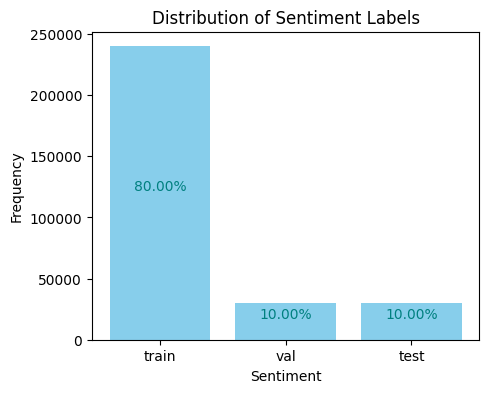

In [13]:
split_name = ['train', 'val', 'test']
split_df = [len_train, len_val, len_test]

plt.figure(figsize=(5, 4))
bars = plt.bar(x=split_name, height=split_df, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height - (height/2.0), '%0.2f%s' % ((height/len_df)*100, '%'), ha='center', va='bottom', color='teal')

plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

## Preparation for training

In [14]:
# split for training portion
X_train, y_train = train_df['sentiment'], train_df['label']
X_val, y_val = val_df['sentiment'], val_df['label']
X_test, y_test = test_df['sentiment'], test_df['label']

### Hyperparameters

In [15]:
# Vocabulary size of the tokenizer
vocab_size = 10000

# Maximum length of the padded sequences
max_length = 50

# Output dimensions of the Embedding layer
embedding_dim = 16

### Tokenize data

In [16]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [17]:
print(len(word_index))

122232


In [18]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train)
label_index_word = label_tokenizer.index_word

# start encoder label from 0
labels_encoder = {key - 1: value for key, value in label_index_word.items()}

# Tokenize the label
training_labels = label_tokenizer.texts_to_sequences(y_train)
val_labels = label_tokenizer.texts_to_sequences(y_val)
test_labels = label_tokenizer.texts_to_sequences(y_test)

In [19]:
print(labels_encoder)

{0: 'positive', 1: 'neutral', 2: 'negative'}


In [20]:
# convert labels list to np array
# Below arrays are subtracted by one, because all index should start from 0, instead the current label before subtract started with one
training_labels = np.array(training_labels) - 1
val_labels = np.array(val_labels) - 1
test_labels = np.array(test_labels) - 1

print(training_labels.shape)
print(val_labels.shape)
print(test_labels.shape)
len(training_labels), len(val_labels), len(test_labels)

(239998, 1)
(30000, 1)
(30000, 1)


(239998, 30000, 30000)

### Sequence data

In [21]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

### padded data

In [22]:
padded_train = pad_sequences(sequences_train, maxlen=max_length, truncating='post', padding='post')
padded_val = pad_sequences(sequences_val, maxlen=max_length, truncating='post', padding='post')
padded_test = pad_sequences(sequences_test,maxlen=max_length, truncating='post', padding='post')

In [23]:
print(padded_train[0], padded_train.shape)
print(padded_val.shape)
print(padded_test.shape)

[ 237   23 1462 2947 1955 4062 9433 7659    4  990    4   45  310   43
   40   24  265    3 9155  184    1   28 7905  184  899   59   74 5503
   61   14  118    1 1874  140  194   25 6497 1353    4    2 3330 4572
   34 3857    5  559    7    2 8562    2] (239998, 50)
(30000, 50)
(30000, 50)


# Build and compile Model

In [ ]:
model = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(24, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 16)            160000    
                                                                 
 global_average_pooling1d_7  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_14 (Dense)            (None, 24)                408       
                                                                 
 dense_15 (Dense)            (None, 3)                 75        
                                                                 
Total params: 160483 (626.89 KB)
Trainable params: 160483 (626.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )

# Model training

In [ ]:
num_epochs=20
history = model.fit(padded_train, training_labels, epochs=num_epochs,
                    validation_data=(padded_val, val_labels), verbose=2)

Epoch 1/20
7500/7500 - 32s - loss: 0.5786 - accuracy: 0.7523 - val_loss: 0.4415 - val_accuracy: 0.8302 - 32s/epoch - 4ms/step
Epoch 2/20
7500/7500 - 31s - loss: 0.4702 - accuracy: 0.8066 - val_loss: 0.3910 - val_accuracy: 0.8584 - 31s/epoch - 4ms/step
Epoch 3/20
7500/7500 - 33s - loss: 0.4556 - accuracy: 0.8126 - val_loss: 0.3335 - val_accuracy: 0.8818 - 33s/epoch - 4ms/step
Epoch 4/20
7500/7500 - 32s - loss: 0.4460 - accuracy: 0.8172 - val_loss: 0.3773 - val_accuracy: 0.8622 - 32s/epoch - 4ms/step
Epoch 5/20
7500/7500 - 31s - loss: 0.4370 - accuracy: 0.8199 - val_loss: 0.3555 - val_accuracy: 0.8709 - 31s/epoch - 4ms/step
Epoch 6/20
7500/7500 - 32s - loss: 0.4286 - accuracy: 0.8235 - val_loss: 0.4029 - val_accuracy: 0.8481 - 32s/epoch - 4ms/step
Epoch 7/20
7500/7500 - 31s - loss: 0.4201 - accuracy: 0.8261 - val_loss: 0.3507 - val_accuracy: 0.8732 - 31s/epoch - 4ms/step
Epoch 8/20
7500/7500 - 31s - loss: 0.4111 - accuracy: 0.8305 - val_loss: 0.3586 - val_accuracy: 0.8711 - 31s/epoch - 4

# Visualize the results

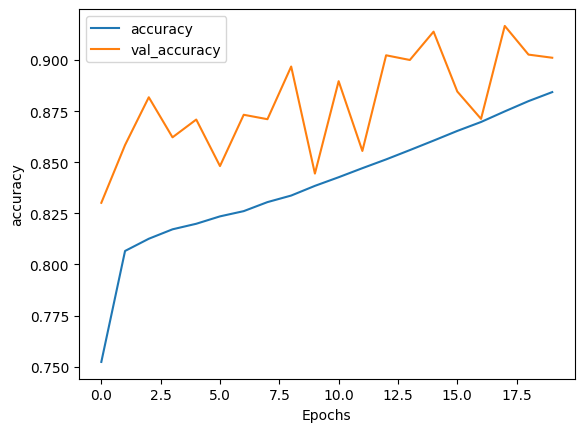

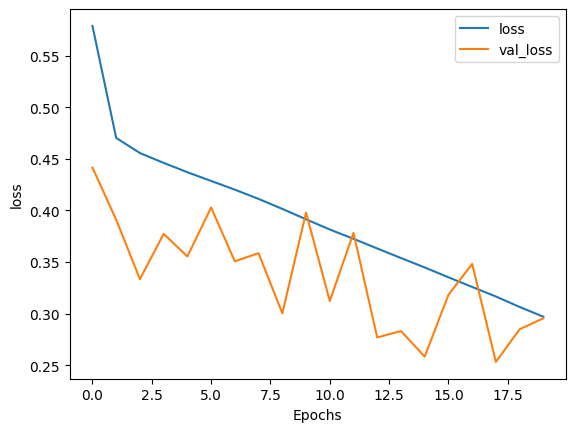

In [ ]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Save HDF5 model

In [ ]:
# Save the model
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluate the model

In [36]:
def download_model():
  model_url = 'https://github.com/sayid-alt/sentiment-analysis-nlp/raw/main/model/model.h5'
  urllib.request.urlretrieve(model_url, 'model.h5')
  print('Success downloading model')

download_model()

Success downloading model


In [38]:
loaded_model = tf.keras.models.load_model('model.h5')
loaded_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 16)            160000    
                                                                 
 global_average_pooling1d_7  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_14 (Dense)            (None, 24)                408       
                                                                 
 dense_15 (Dense)            (None, 3)                 75        
                                                                 
Total params: 160483 (626.89 KB)
Trainable params: 160483 (626.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
loss, accuracy = loaded_model.evaluate(padded_test, test_labels)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

938/938 [==============================] - 2s 2ms/step - loss: 0.2908 - accuracy: 0.9044
Loss: 0.29075610637664795
Accuracy: 0.904366672039032


# Prediction

In [40]:
# predict the test labels from dataset

# show prediction softmax probability
prediction = loaded_model.predict(test_labels)
print(prediction)

# show one hot prediction based on the highest prob
predicted_labels = (prediction > 0.5).astype(int)
print(predicted_labels)

938/938 [==============================] - 1s 2ms/step
[[0.00102617 0.9834393  0.01553443]
 [0.00102617 0.9834393  0.01553443]
 [0.00102617 0.9834393  0.01553443]
 ...
 [0.00102617 0.9834393  0.01553443]
 [0.00102617 0.9834393  0.01553443]
 [0.00102617 0.9834393  0.01553443]]
[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


## Input user

In [29]:
user_input = input('Enter a sentence: ')

# tokenize the sentence
user_sequence = tokenizer.texts_to_sequences([user_input])

# pad the sequence
user_padded = pad_sequences(user_sequence, maxlen=max_length, truncating='post', padding='post')

# predict the sentiment
prediction = loaded_model.predict(user_padded)

Enter a sentence: This service is bad
1/1 [==============================] - 0s 30ms/step


## Summary Prediction

In [30]:
print('---- Prediction summary -----')
print(labels_encoder)
print('Softmax probability:', prediction)

# return the highest probability of 3 categories
predicted_index = np.argmax(prediction, axis=1)

# get the predicted label based on highest probability
predicted_label = labels_encoder[predicted_index[0]]
print(f'Predicted sentiment: {predicted_label}')

---- Prediction summary -----
{0: 'positive', 1: 'neutral', 2: 'negative'}
Softmax probability: [[0.00145868 0.03060106 0.9679403 ]]
Predicted sentiment: negative


# Deployment

## Using Pickle

In [35]:
with open('model.pkl', 'wb') as file:
  pickle.dump(loaded_model, file)

In [ ]:
files.download('model.pkl')